# Mini-projet: Tomographie à rayons X


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rotate, resize

On commence par charger une image synthétique (le "Shepp-Logan phantom") dont on fixe la taille à 256 x 256 pixels. Le Shepp-Logan phantom est une image de test standard créée par Larry Shepp et Benjamin F. Logan en 1974 et qui sert de modèle d'acquisition d'une tête humaine dans le développement et le test d'algorithmes de reconstruction d'images.

In [2]:
# Load the image
N = 256
image = shepp_logan_phantom()
image = resize(image, (N, N), anti_aliasing=True)


## Q.1.1. Transformée de Radon

**En utilisant la fonction *rotate* de scikit-image, implémenter une fonction permettant de calculer la transformée de Radon d'une image, appelée également sinogramme de l'image.**

Pour un angle donné, on peut calculer la transformée de Radon de l'image en appliquant une rotation à l'image dans le sens inverse des aiguilles d'une montre et en sommant la valeur des pixels de l'image obtenue après rotation ligne par ligne.

In [3]:
def radon_transform(image, theta):
    
    """
    Computes the Radon transform of the image
    
    Parameters
    ----------
    
    image: 2D numpy array
      input image
      
    theta: 1D numpy array
      angles (specified in degrees)
    
    Return
    ------
    
    out: numpy array
      Radon transform (sinogram) of the input image
      
    """

    Rf = []
    for angle in theta :
      image_rot = rotate(image, angle)
      Rf.append(np.sum(image_rot, axis = 1))
    return np.array(Rf)

In [4]:
# Computes the Radon transform of the image 
N_t = 256
angles_count = 180
theta = np.linspace(0., 180., angles_count, endpoint=False)
sinogram = radon_transform(image, theta=theta)

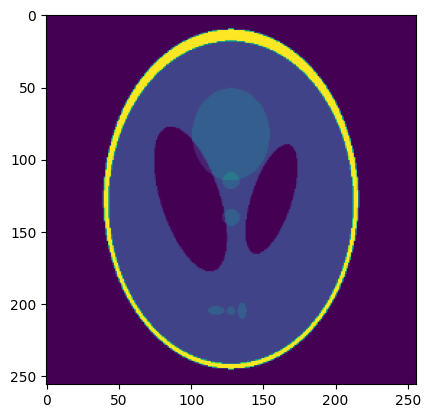

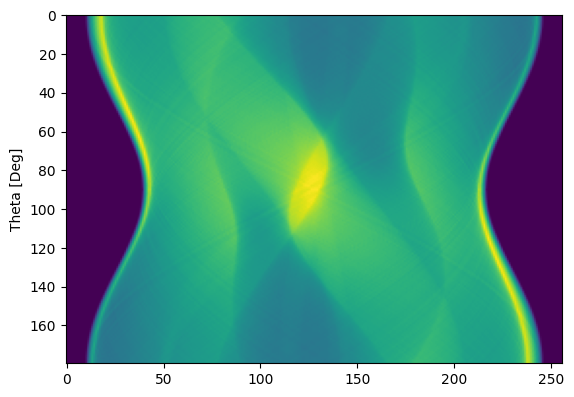

In [5]:
# Display the original image along with its sinogram
plt.imshow(image)
plt.show()
plt.imshow(sinogram)
plt.ylabel("Theta [Deg]")
plt.show()

**2.** Montrer que la transformée de Fourier de $t \mapsto Rf (\theta, t)$ est donnée, pour tout $\theta \in [0, 2\pi]$ et
pour tout $\omega \in \mathbb{R}$, par :
$$\widehat{Rf (\theta, ·)}(\omega) = Ff (\omega cos \theta, \omega sin \theta)$$

**Réponse :**

$$
\begin{split}
\widehat{Rf (\theta, ·)}(\omega)
& = \int_{\mathbb{R}}{Rf (\theta, t)\exp(-i\omega t)dt} \\
& = \int_{\mathbb{R}}{\left( \int_{\mathbb{R}}{f(t cos \theta − \rho sin \theta, t sin \theta + \rho cos \theta)d\rho} \right)\exp(-i\omega t)dt}\\
\end{split}
$$

On pose $u = t cos \theta − \rho sin \theta$ et $ v=t sin \theta + \rho cos \theta$.
On remarque que $\begin{pmatrix} u \\ v \end{pmatrix} = \begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{pmatrix}\begin{pmatrix} t \\ \rho \end{pmatrix}$, inversible (rotation d'angle $\theta$)

On remarque que le déterminant de la jacobienne de cette transformation est $1$. Ainsi, en inversant la matrice, on obtient $t = ucos\theta + vsin\theta$.

En réinjectant, il vient :

$$
\begin{split}
\widehat{Rf (\theta, ·)}(\omega)
& = \int_{\mathbb{R}}{\left( \int_{\mathbb{R}}{f(t cos \theta − \rho sin \theta, t sin \theta + \rho cos \theta)d\rho} \right)\exp(-i\omega t)dt}\\
& = \int{\int_{\mathbb{R}^2}{f(u, v)}\exp(-i\omega (ucos\theta + vsin\theta))dudv} \\
& = \boxed{Ff (\omega cos \theta, \omega sin \theta)}
\end{split}
$$

## Q.2.2. Rétroprojection

### 2.1 - Réponse

On commence par caluler $Rf (\theta, t)$. On a vu à la question précédente que $\begin{pmatrix} u \\ v \end{pmatrix} = \begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{pmatrix}\begin{pmatrix} t \\ \rho \end{pmatrix}$, où $u$ et $v$ sont ceux définis plus haut. On a donc une rotation autour du centre du repère d'angle $\theta$ du vecteur $\begin{pmatrix} t \\ \rho \end{pmatrix}$. Mais alors le vecteur $\begin{pmatrix} u \\ v \end{pmatrix}$ appartient au disque unité si, et seulement si $\begin{pmatrix} t \\ \rho \end{pmatrix}$ y appartient. 

Ainsi,

$$
\begin{split}
Rf(\theta,t) & = \begin{cases}
      0 \text{ si } |{t}| > 1\\
      \int_{-\sqrt{1-t^2}}^{\sqrt{1-t^2}}{d\rho} \ \text {sinon}
\end{cases} \\ 
& = {\begin{cases}
      0 \text{ si } |{t}| > 1\\
      2\sqrt{1-t^2} \ \text {sinon}
\end{cases}} \\
\end{split}
$$

On en déduit :

$$
\boxed{\tilde{f}(x,y) = \frac{2}{\pi}\int_0^{\pi}{\mathbb{1}_{[-1,1]}(x cos \theta + y sin \theta)\sqrt{1-(x cos \theta + y sin \theta)^2}d\theta}}
$$

Ce n'est pas une formule d'inversion : pour $(x, y) = (0, 0)$, on a 
\begin{align*}
\tilde{f}(x,y) &=  \frac{2}{\pi} \int_0^{\pi}{1 \cdot \sqrt 1} \\
&= \frac{2}{\pi} \cdot \pi \\
&= 2
\end{align*}

Alors que $f(0, 0) = 1$.

In [6]:
test = np.array([[1,2],[3,4]])
print(test[0,1])
np.sum(test,axis = 1)

2


array([3, 7])

**Implémenter la reconstruction de l'image tomographique à partir du sinogramme par rétro-projection. Commenter le résultat.**

In [7]:
def backproj_lent(g, N_t, angles_count, N):
    
    """
    Backprojection
    
    Parameters
    ----------
    
    g: N_t x angle_count array
      image sinogram
    N_t: int
      number of projection positions
    angles_count: int
      number of angular projections
    N: int
      image size
      
    Return
    ------
    
    reconstructed: N x N numpy array
      reconstructed image
    """

    reconstructed = np.zeros((N,N))
    deltatheta = 180./angles_count

    for x in range(-N_t//2,N_t//2):
        for y in range(-N_t//2,N_t//2):
          
          tot = 0

          for k in range(angles_count):
            
            t = x*np.cos(np.radians(k*deltatheta)) + y*np.sin(np.radians(k*deltatheta))

            t_mapped = int(np.round(t/(np.sqrt(2)) + N_t/2))
            
            tot += g[k,t_mapped]*deltatheta
        
          reconstructed[x + N//2,y + N//2] = 1/np.pi * tot

    return reconstructed       

In [8]:
def backproj(g, N_t, angles_count, N):
    
    """
    Backprojection
    
    Parameters
    ----------
    
    g: N_t x angle_count array
      image sinogram
    N_t: int
      number of projection positions
    angles_count: int
      number of angular projections
    N: int
      image size
      
    Return
    ------
    
    reconstructed: N x N numpy array
      reconstructed image
    """
    deltatheta = 180./angles_count

    reconstructed = np.zeros((N,N))
    x_tab = np.arange(-N_t//2,N_t//2, 1)
    y_tab = np.arange(-N_t//2,N_t//2, 1)
    k_tab = np.arange(0, angles_count, 1)
    x_grid, y_grid, k_grid = np.meshgrid(x_tab, y_tab, k_tab, indexing='ij')

    
    theta = np.radians(k_grid * deltatheta)
    t_mapped = np.int32(np.round((x_grid * np.cos(theta) + y_grid * np.sin(theta)) / np.sqrt(2) + N_t / 2))

    t_mapped = np.clip(t_mapped, 0, N_t - 1)

    g_expanded = g[np.newaxis, np.newaxis, :, :]                   
    t_mapped_exp = t_mapped[..., np.newaxis]                      

    g_vals = np.take_along_axis(g_expanded, t_mapped_exp, axis=3) 
    g_vals = g_vals[..., 0]                                       

    tot = np.sum(g_vals, axis=2) * deltatheta

    reconstructed = (1 / np.pi) * tot

    return reconstructed 

In [9]:
f = backproj(sinogram, N_t, angles_count, N)

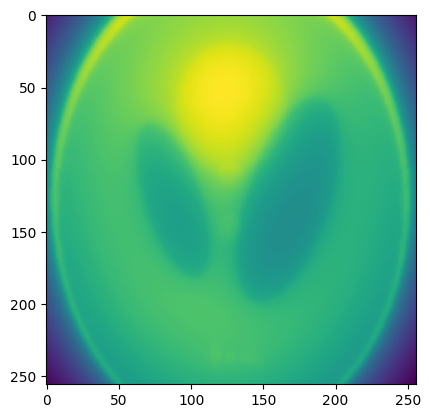

In [10]:
plt.imshow(f)
plt.show()

In [43]:
N_t

256

##  Q.2.3. Rétro-projection filtrée

**Appliquer un filtrage adapté au sinogramme avant de rétro-projeter. Afficher le sinogramme filtré ainsi que le résultat de la reconstruction.**


In [ ]:
# On nous donne la TF du filtre à basses fréquences : pas très clair est-ce qu'on 
# considère que le filtre est toujours à basse fréquence ? Parce que il faut choisir la limite pour faire les 
# calculs avec le filtre. Du coup je prends fmax = 30 (voir graphique à la fin)
# Ah et dans l'énoncé ils mettent theta en 2e variable alors que c'est la 1ere. Erreur ?

Brouillon explications du choix : 

On utilise le lien entre produit de convolution avec réponse impulsionnelle et produit des TF. Donc il me faut la TF de Rf. Mais je ne peux l'appliquer que pour des valeurs faibles de $\omega$ (un peu arbitraire comme terme certes). Il s'avère que la TF de Rf est du même ordre de grandeur que Ff, donc pour les calculs on regarde Ff, et on voit qu'elle décroît très rapidement. 
Alors on calcule la FFT de Rf sur toute l'image et on la prend à $\theta$ constant, ce qui coïncide avec le fait de fixer $\theta$ puis de prendre la TF.

In [ ]:
def filter_sinogram(sinogram, N_t):

    """
    Filter the sinogram
    
    Parameters
    ----------
    
    sinogram: numpy array
      sinogram
    N_t: int
      number of projection positions
      
    Return
    ------
    
    reconstructed: N_t x angle_counts numpy array
      reconstructed sinogram
    """
    sino_FFT = np.fft.fft(sinogram)
    omega = np.fft.freq(N_t, 1)

    # Bref j'ai tout fais faut juste que je l'écrive mais ce soir j'ai la flemme donc touche pas je m'en occupe
    

    

In [ ]:
filtered_sinogram = filter_sinogram(sinogram, N_t)

In [42]:
a = np.array([1, 2, 3])
np.tile(a, (4, 1))
np.fft.fftfreq(N_t, 1)

array([ 0.        ,  0.00390625,  0.0078125 ,  0.01171875,  0.015625  ,
        0.01953125,  0.0234375 ,  0.02734375,  0.03125   ,  0.03515625,
        0.0390625 ,  0.04296875,  0.046875  ,  0.05078125,  0.0546875 ,
        0.05859375,  0.0625    ,  0.06640625,  0.0703125 ,  0.07421875,
        0.078125  ,  0.08203125,  0.0859375 ,  0.08984375,  0.09375   ,
        0.09765625,  0.1015625 ,  0.10546875,  0.109375  ,  0.11328125,
        0.1171875 ,  0.12109375,  0.125     ,  0.12890625,  0.1328125 ,
        0.13671875,  0.140625  ,  0.14453125,  0.1484375 ,  0.15234375,
        0.15625   ,  0.16015625,  0.1640625 ,  0.16796875,  0.171875  ,
        0.17578125,  0.1796875 ,  0.18359375,  0.1875    ,  0.19140625,
        0.1953125 ,  0.19921875,  0.203125  ,  0.20703125,  0.2109375 ,
        0.21484375,  0.21875   ,  0.22265625,  0.2265625 ,  0.23046875,
        0.234375  ,  0.23828125,  0.2421875 ,  0.24609375,  0.25      ,
        0.25390625,  0.2578125 ,  0.26171875,  0.265625  ,  0.26

In [ ]:
# Display the sinogram and the filtered sinogram

In [ ]:
# Filtered backpropagation
frec = backproj(filtered_sinogram, N_t, angles_count, N)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Display the reconstructed and the original images

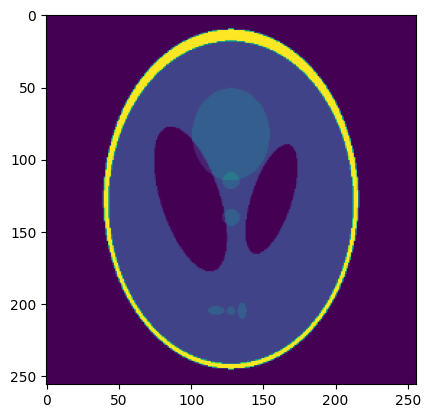

In [24]:
plt.imshow(image)

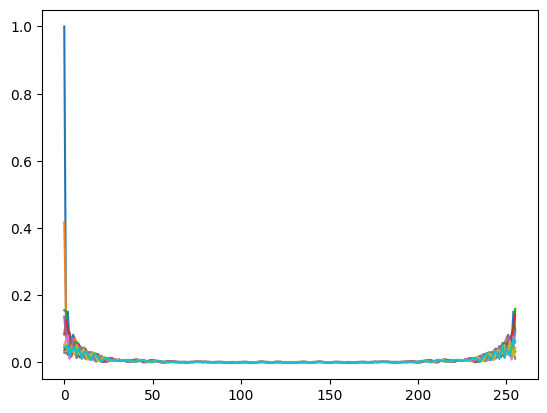

In [37]:
Imfft = np.abs(np.fft.fft2(image))
Imfft = Imfft/np.max(Imfft)
for i in range(10):
    plt.plot(Imfft[:, i])
